In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Define paths
DATA_PATH = "/content/drive/MyDrive/Modelo_Taxonomico/Class"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")
# Define Class
csv_file = '/content/drive/MyDrive/Modelo_Taxonomico/CSV/data_def.csv'
df = pd.read_csv(csv_file)
classes = df['class'].unique().tolist()
# Define image size
SIZE=224
IM_SIZE = (224, 224, 3)
# Define batch size
BATCH_SIZE = 8

In [11]:
print(classes)

['EM', 'BI', 'TM', 'GE', 'VI', 'S', 'MH']


In [12]:
# Create data generators
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)

train_batches = train_datagen.flow_from_directory(
    TRAIN_PATH,
    classes=classes,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_batches = valid_datagen.flow_from_directory(
    VAL_PATH,
    classes=classes,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_batches = test_datagen.flow_from_directory(
    TEST_PATH,
    classes=classes,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 13374 images belonging to 7 classes.
Found 1670 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.


## Finetuning B3 EfficientNet

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights

In [8]:
def build_model(num_classes):
    base_model = EfficientNetB3(
        include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE
    )
    x = base_model.output
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation="softmax", name="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(
        optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [13]:
# Estimate class weights for unbalanced dataset
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(train_batches.classes), y=train_batches.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [14]:
# ModelCheckpoint callback
ModelCheck = ModelCheckpoint(
    "/content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/efficientnet_b7_tuned.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq='epoch',
)

In [9]:
# ReduceLR callback
ReduceLR = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=3e-4
)

In [10]:
# EarlyStopping callback
EarlyStop = EarlyStopping(
    monitor="val_loss", patience=10, verbose=1, mode="auto"
)

In [15]:
# Build and summarize the model
model = build_model(num_classes=len(classes))
model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [ ]:
# Train the model
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=30,
    callbacks=[ModelCheck, ReduceLR, EarlyStop],
    class_weight=class_weights_dict,
    workers=4
)

Epoch 1/30
1672/1672 [==============================] - ETA: 0s - loss: 4.1298 - accuracy: 0.4680
Epoch 1: val_loss improved from inf to 2.41687, saving model to /content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/efficientnet_b7_tuned.h5
1672/1672 [==============================] - 1987s 1s/step - loss: 4.1298 - accuracy: 0.4680 - val_loss: 2.4169 - val_accuracy: 0.5551 - lr: 0.0010
Epoch 2/30
1672/1672 [==============================] - ETA: 0s - loss: 2.3859 - accuracy: 0.5455
Epoch 2: val_loss improved from 2.41687 to 1.18145, saving model to /content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/efficientnet_b7_tuned.h5
1672/1672 [==============================] - 368s 220ms/step - loss: 2.3859 - accuracy: 0.5455 - val_loss: 1.1815 - val_accuracy: 0.6407 - lr: 0.0010
Epoch 3/30
1672/1672 [==============================] - ETA: 0s - loss: 1.5934 - accuracy: 0.6074
Epoch 3: val_loss did not improve from 1.18145
1672/1672 [==============================] - 366s 218ms/step - loss: 

In [ ]:
# Plot training history
plot_hist(history)

In [16]:
# Load weights from the file
model.load_weights("/content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/efficientnet_b7_tuned.h5")

In [ ]:
!pip install scikit-learn seaborn

#Matriz de Confusion

210/210 [==============================] - 1026s 5s/step


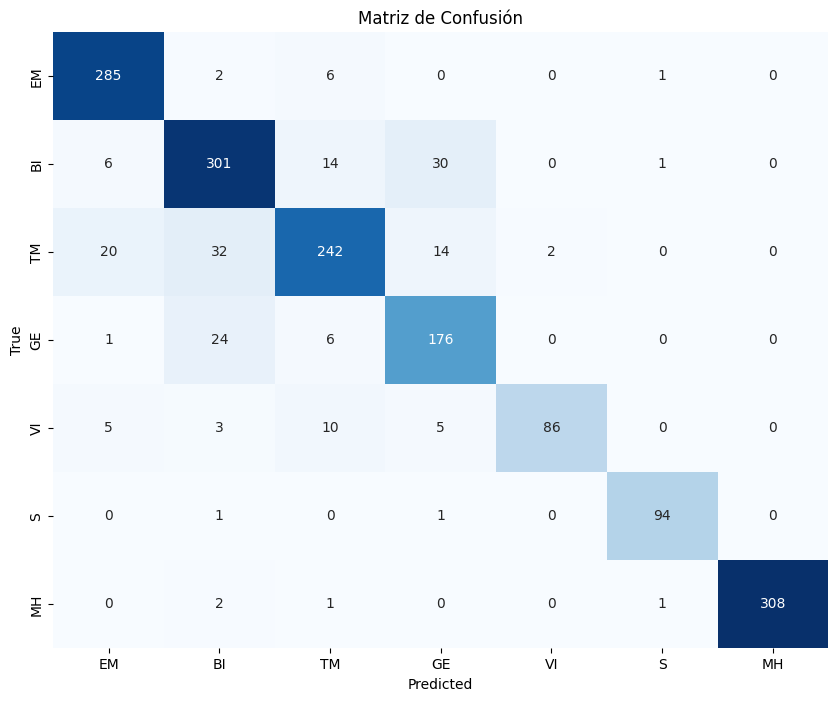


Informe de clasificación:
               precision    recall  f1-score   support

          EM       0.90      0.97      0.93       294
          BI       0.82      0.86      0.84       352
          TM       0.87      0.78      0.82       310
          GE       0.78      0.85      0.81       207
          VI       0.98      0.79      0.87       109
           S       0.97      0.98      0.97        96
          MH       1.00      0.99      0.99       312

    accuracy                           0.89      1680
   macro avg       0.90      0.89      0.89      1680
weighted avg       0.89      0.89      0.89      1680



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el modelo con los pesos
model.load_weights("/content/drive/MyDrive/Modelo_Taxonomico/Modelo/Weight/efficientnet_b7_tuned.h5")

# Predecir las clases para el conjunto de prueba
y_pred = model.predict(test_batches)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las clases reales
y_true = test_batches.classes

# Calcular la matriz de confusión
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Mostrar el informe de clasificación
print("\nInforme de clasificación:\n", classification_report(y_true, y_pred_classes, target_names=classes))

# Calcular nuevas metricas

In [21]:
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, confusion_matrix,roc_auc_score

# Extraer testing data
test_predictions_enc = model.predict(test_batches)#001,010,011,100,101..
test_predictions = np.argmax(test_predictions_enc, axis=-1)#0,1,2,3,4--> INT


# Extraer true data
test_data = []
test_labels = []
for i in range(len(test_batches)):
    batch = test_batches[i]
    test_data.append(batch[0])
    test_labels.append(batch[1])

test_data = np.concatenate(test_data)
test_labels_enc = np.concatenate(test_labels)
test_labels = np.argmax(test_labels_enc, axis=1)


210/210 [==============================] - 236s 1s/step


In [22]:
assert test_predictions.shape== test_labels.shape, "this should match!"

In [23]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_batches, verbose=1)
test_accuracy_percent = test_accuracy * 100

# Calculate precision, recall, and specificity (micro-averaged)
precision = precision_score(test_labels, test_predictions, average='micro')
recall = recall_score(test_labels, test_predictions, average='micro')

# Calculate true negatives, false positives, and specificity (micro-averaged)
tn = np.sum((test_labels != 1) & (test_predictions != 1))
fp = np.sum((test_labels != 1) & (test_predictions == 1))
specificity = tn / (tn + fp)

# Calculate F1 score (weighted average)
f1 = f1_score(test_labels, test_predictions, average='weighted')

# Print the evaluation metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_percent, "%")
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy_percent, "%")

print("test_predictions Shape:", test_predictions.shape)
print("test_labels Shape:", test_labels.shape)
print("F1 Score:", f1)

210/210 [==============================] - 233s 1s/step - loss: 0.3897 - accuracy: 0.8881
Test Loss: 0.3896900415420532
Test Accuracy: 88.80952596664429 %
F1 Score: 0.8877950983997913
Precision: 0.888095238095238
Recall: 0.888095238095238
Specificity: 0.9518072289156626
Test Loss: 0.3896900415420532
Test Accuracy: 88.80952596664429 %
test_predictions Shape: (1680,)
test_labels Shape: (1680,)
F1 Score: 0.8877950983997913
